# SVM Classification for EEG Visual Evoked Potentials

## Dataset: 4 Classes Classification
- **Apple** (Class 1)
- **Car** (Class 2)
- **Flower** (Class 3)
- **Human Face** (Class 4)

## Method: Stratified 5-Fold Cross-Validation
- Ensures balanced class distribution in each fold
- Robust evaluation across multiple train/test splits

## 1. Import Required Libraries

### Check GPU Availability

In [1]:
# Simple GPU check (fast version)
USE_GPU = False
device = 'cpu'
THUNDERSVM_AVAILABLE = False

print("Checking GPU availability...")
print("="*60)

# Try PyTorch (skip if takes too long)
try:
    import torch
    if torch.cuda.is_available():
        USE_GPU = True
        device = 'cuda'
        print("✅ GPU FOUND!")
        print(f"   Device: {torch.cuda.get_device_name(0)}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        print("⚠️  PyTorch installed but CUDA unavailable")
except:
    print("⚠️  PyTorch not installed or failed to load")

# Check ThunderSVM
try:
    from thundersvm import SVC as ThunderSVC
    THUNDERSVM_AVAILABLE = True
    print("✅ ThunderSVM available (GPU-accelerated SVM)")
except:
    pass

print("="*60)
print(f"Training mode: {'GPU' if USE_GPU else 'CPU'}")
print(f"SVM library: {'ThunderSVM' if THUNDERSVM_AVAILABLE else 'scikit-learn'}")


Checking GPU availability...


c:\Users\admin\AppData\Local\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ GPU FOUND!
   Device: NVIDIA GeForce RTX 3060 Laptop GPU
   Memory: 6.44 GB
Training mode: GPU
SVM library: scikit-learn
Training mode: GPU
SVM library: scikit-learn


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.0.3


## 2. Load CSV Data from All Classes

In [3]:
# Define data directory
DATA_DIR = Path("CSV-FEATURES")

# Class mapping
class_names = ['Apple', 'Car', 'Flower', 'Human Face']
class_map = {1: 'Apple', 2: 'Car', 3: 'Flower', 4: 'Human Face'}

# Load all CSV files
print("Loading CSV files...")
all_data = []

for class_name in class_names:
    class_path = DATA_DIR / class_name
    csv_files = list(class_path.rglob("*_epochs.csv"))
    print(f"\n{class_name}: Found {len(csv_files)} files")
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        all_data.append(df)
        print(f"  - {csv_file.name}: {len(df)} epochs")

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)

print(f"\n✅ Total epochs loaded: {len(df_all)}")
print(f"Shape: {df_all.shape}")
print(f"\nClass distribution:")
print(df_all['Class'].value_counts().sort_index())

Loading CSV files...

Apple: Found 12 files
  - Apple_A1_sub15_A1_RAW14_epochs.csv: 36 epochs
  - Apple_A1_sub20_A1_RAW14_epochs.csv: 1 epochs
  - Apple_A1_sub29_A1_RAW14_epochs.csv: 57 epochs
  - Apple_A1_sub32_A1_RAW14_epochs.csv: 19 epochs
  - Apple_A1_sub3_A1_RAW14_epochs.csv: 95 epochs
  - Apple_A1_sub6_A1_RAW14_epochs.csv: 79 epochs
  - Apple_A1_sub8_A1_RAW14_epochs.csv: 11 epochs
  - Apple_A2_sub10_A2_RAW14_epochs.csv: 86 epochs
  - Apple_A1_sub3_A1_RAW14_epochs.csv: 95 epochs
  - Apple_A1_sub6_A1_RAW14_epochs.csv: 79 epochs
  - Apple_A1_sub8_A1_RAW14_epochs.csv: 11 epochs
  - Apple_A2_sub10_A2_RAW14_epochs.csv: 86 epochs
  - Apple_A2_sub12_A2_RAW14_epochs.csv: 108 epochs
  - Apple_A2_sub30_A2_RAW14_epochs.csv: 40 epochs
  - Apple_A2_sub5_A2_RAW14_epochs.csv: 81 epochs
  - Apple_A2_sub9_A2_RAW14_epochs.csv: 33 epochs

Car: Found 15 files
  - Car_C1_sub11_C1_RAW14_epochs.csv: 96 epochs
  - Apple_A2_sub12_A2_RAW14_epochs.csv: 108 epochs
  - Apple_A2_sub30_A2_RAW14_epochs.csv: 40 e

## 3. Prepare Features and Labels

Features shape: (3612, 1792)
Labels shape: (3612,)

Feature dimensions: 1792 features
  - 14 channels × 128 timepoints = 1792 features

NaN values: 0
Inf values: 0


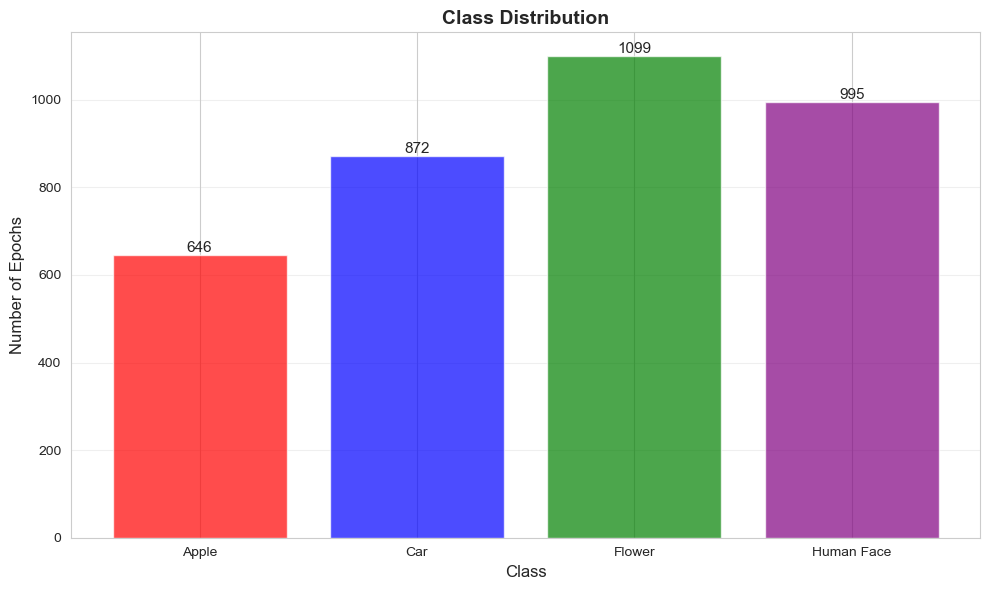

In [4]:
# Separate features (X) and labels (y)
# Remove metadata columns: Class, Phase, Subject
X = df_all.iloc[:, :-3].values  # All EEG features
y = df_all['Class'].values       # Class labels (1, 2, 3, 4)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFeature dimensions: {X.shape[1]} features")
print(f"  - 14 channels × 128 timepoints = {14*128} features")

# Check for NaN or Inf values
print(f"\nNaN values: {np.isnan(X).sum()}")
print(f"Inf values: {np.isinf(X).sum()}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = pd.Series(y).value_counts().sort_index()
bars = plt.bar([class_map[i] for i in class_counts.index], class_counts.values, 
               color=['red', 'blue', 'green', 'purple'], alpha=0.7)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Epochs', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Setup Stratified 5-Fold Cross-Validation

In [5]:
# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage for results
fold_results = {
    'accuracy': [],
    'f1_macro': [],
    'f1_weighted': [],
    'precision_macro': [],
    'recall_macro': [],
    'confusion_matrices': []
}

print(f"✅ Stratified {n_splits}-Fold Cross-Validation initialized")
print(f"Random state: 42 (reproducible results)")
print(f"\nData will be split into:")
print(f"  - Training: ~{100*(n_splits-1)/n_splits:.1f}% per fold")
print(f"  - Testing: ~{100/n_splits:.1f}% per fold")

✅ Stratified 5-Fold Cross-Validation initialized
Random state: 42 (reproducible results)

Data will be split into:
  - Training: ~80.0% per fold
  - Testing: ~20.0% per fold


## 5. Train SVM with RBF Kernel (5-Fold CV)

In [6]:
print("="*60)
print(f"Training SVM with RBF Kernel - 5-Fold Cross-Validation ({'GPU' if USE_GPU else 'CPU'})")
print("="*60)

fold_num = 1

for train_idx, test_idx in skf.split(X, y):
    print(f"\n{'='*60}")
    print(f"FOLD {fold_num}/{n_splits}")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM with RBF kernel
    if USE_GPU and THUNDERSVM_AVAILABLE:
        # Option 1: ThunderSVM (fastest for large datasets)
        print(f"\nTraining ThunderSVM (RBF kernel) on GPU...")
        svm_model = ThunderSVC(kernel='rbf', C=1.0, gamma='scale', gpu_id=0)
        svm_model.fit(X_train_scaled, y_train)
        y_pred = svm_model.predict(X_test_scaled)
        y_test_cpu = y_test
        
    elif USE_GPU:
        # Option 2: Move data to GPU with PyTorch, train on CPU but benefit from GPU memory
        print(f"\nTraining SVM (RBF kernel) with GPU-accelerated data transfer...")
        import torch
        
        # Transfer to GPU
        X_train_gpu = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        X_test_gpu = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        
        # Train on CPU (sklearn SVM is CPU-only, but we prepare data on GPU)
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        
        # Transfer back to CPU for training (sklearn requires CPU)
        X_train_cpu = X_train_gpu.cpu().numpy()
        X_test_cpu = X_test_gpu.cpu().numpy()
        
        svm_model.fit(X_train_cpu, y_train)
        y_pred = svm_model.predict(X_test_cpu)
        y_test_cpu = y_test
        
        # Clear GPU memory
        del X_train_gpu, X_test_gpu
        torch.cuda.empty_cache()
        
    else:
        # Option 3: Pure CPU training
        print(f"\nTraining SVM (RBF kernel) on CPU...")
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm_model.fit(X_train_scaled, y_train)
        y_pred = svm_model.predict(X_test_scaled)
        y_test_cpu = y_test
    
    # Calculate metrics (on CPU)
    accuracy = accuracy_score(y_test_cpu, y_pred)
    f1_macro = f1_score(y_test_cpu, y_pred, average='macro')
    f1_weighted = f1_score(y_test_cpu, y_pred, average='weighted')
    precision = precision_score(y_test_cpu, y_pred, average='macro')
    recall = recall_score(y_test_cpu, y_pred, average='macro')
    cm = confusion_matrix(y_test_cpu, y_pred)
    
    # Store results
    fold_results['accuracy'].append(accuracy)
    fold_results['f1_macro'].append(f1_macro)
    fold_results['f1_weighted'].append(f1_weighted)
    fold_results['precision_macro'].append(precision)
    fold_results['recall_macro'].append(recall)
    fold_results['confusion_matrices'].append(cm)
    
    # Print results
    print(f"\n✅ Fold {fold_num} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score (Macro): {f1_macro:.4f}")
    print(f"  F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"  Precision (Macro): {precision:.4f}")
    print(f"  Recall (Macro): {recall:.4f}")
    
    fold_num += 1

print(f"\n{'='*60}")
print("CROSS-VALIDATION COMPLETED")
print(f"{'='*60}")


Training SVM with RBF Kernel - 5-Fold Cross-Validation (GPU)

FOLD 1/5
Training samples: 2889
Testing samples: 723
Train class distribution: [  0 516 698 879 796]
Test class distribution: [  0 130 174 220 199]

Training SVM (RBF kernel) with GPU-accelerated data transfer...

✅ Fold 1 Results:
  Accuracy: 0.4329
  F1-Score (Macro): 0.3990
  F1-Score (Weighted): 0.4162
  Precision (Macro): 0.4344
  Recall (Macro): 0.4045

FOLD 2/5
Training samples: 2889
Testing samples: 723
Train class distribution: [  0 517 697 879 796]
Test class distribution: [  0 129 175 220 199]

Training SVM (RBF kernel) with GPU-accelerated data transfer...

✅ Fold 1 Results:
  Accuracy: 0.4329
  F1-Score (Macro): 0.3990
  F1-Score (Weighted): 0.4162
  Precision (Macro): 0.4344
  Recall (Macro): 0.4045

FOLD 2/5
Training samples: 2889
Testing samples: 723
Train class distribution: [  0 517 697 879 796]
Test class distribution: [  0 129 175 220 199]

Training SVM (RBF kernel) with GPU-accelerated data transfer...



## 6. Overall Performance Summary


5-FOLD CROSS-VALIDATION SUMMARY
             Metric     Mean      Std
           Accuracy 0.418601 0.008659
   F1-Score (Macro) 0.374100 0.015315
F1-Score (Weighted) 0.394007 0.013767
  Precision (Macro) 0.435578 0.010131
     Recall (Macro) 0.385120 0.011079


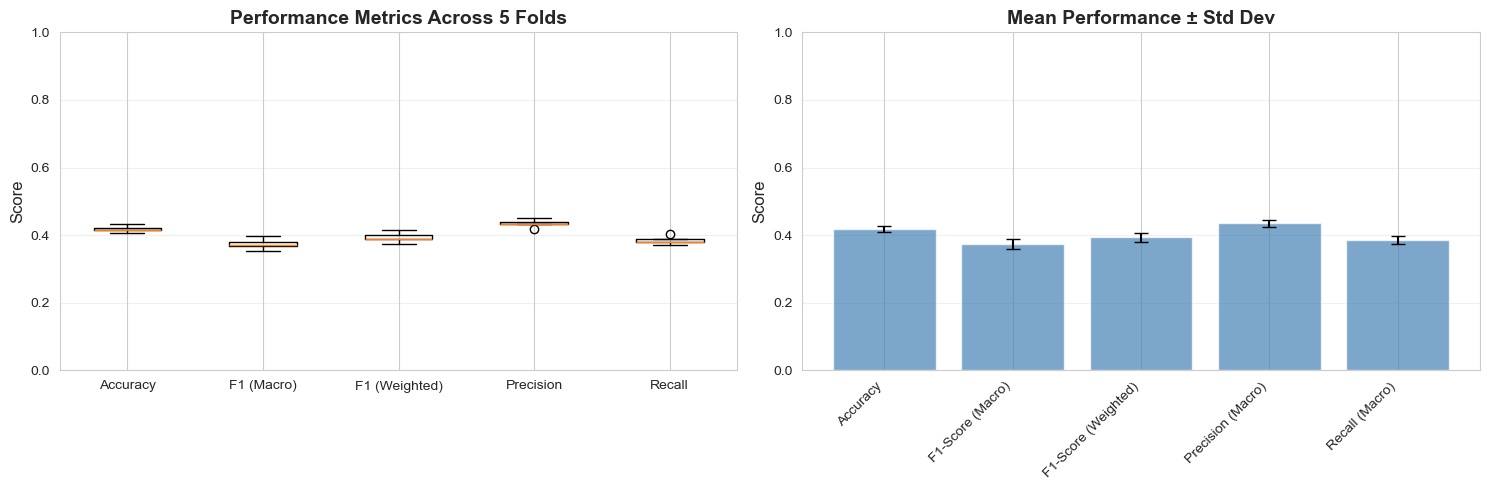

In [7]:
# Calculate mean and std for all metrics
results_summary = {
    'Metric': ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 'Precision (Macro)', 'Recall (Macro)'],
    'Mean': [
        np.mean(fold_results['accuracy']),
        np.mean(fold_results['f1_macro']),
        np.mean(fold_results['f1_weighted']),
        np.mean(fold_results['precision_macro']),
        np.mean(fold_results['recall_macro'])
    ],
    'Std': [
        np.std(fold_results['accuracy']),
        np.std(fold_results['f1_macro']),
        np.std(fold_results['f1_weighted']),
        np.std(fold_results['precision_macro']),
        np.std(fold_results['recall_macro'])
    ]
}

df_summary = pd.DataFrame(results_summary)

print("\n" + "="*60)
print("5-FOLD CROSS-VALIDATION SUMMARY")
print("="*60)
print(df_summary.to_string(index=False))
print("="*60)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Box plot of metrics across folds
metrics_data = pd.DataFrame({
    'Accuracy': fold_results['accuracy'],
    'F1 (Macro)': fold_results['f1_macro'],
    'F1 (Weighted)': fold_results['f1_weighted'],
    'Precision': fold_results['precision_macro'],
    'Recall': fold_results['recall_macro']
})

axes[0].boxplot(metrics_data.values, labels=metrics_data.columns)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics Across 5 Folds', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Bar plot with error bars
x_pos = np.arange(len(df_summary))
axes[1].bar(x_pos, df_summary['Mean'], yerr=df_summary['Std'], 
            capsize=5, alpha=0.7, color='steelblue')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(df_summary['Metric'], rotation=45, ha='right')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Mean Performance ± Std Dev', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 7. Confusion Matrix Visualization

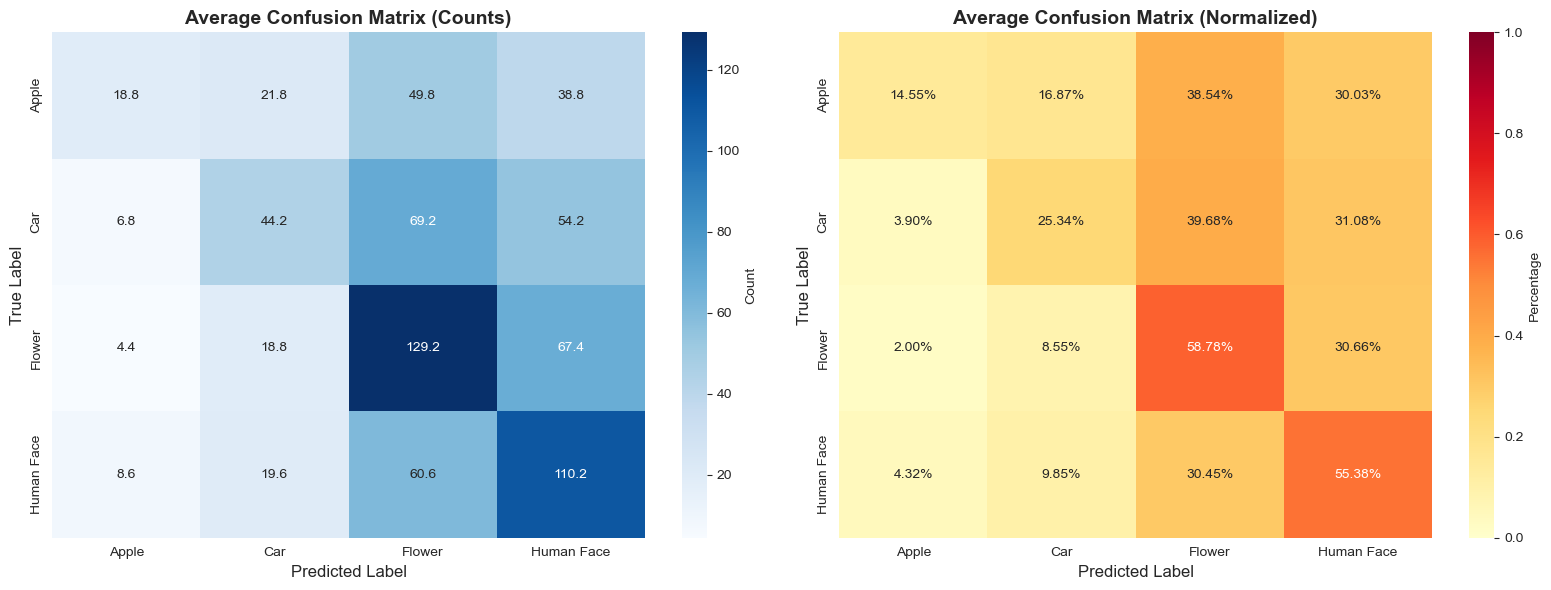


Per-Class Accuracy:
  Apple: 14.55%
  Car: 25.34%
  Flower: 58.78%
  Human Face: 55.38%


In [8]:
# Average confusion matrix across all folds
avg_cm = np.mean(fold_results['confusion_matrices'], axis=0)
avg_cm_normalized = avg_cm / avg_cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw counts
sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Average Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2: Normalized (percentages)
sns.heatmap(avg_cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Average Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = avg_cm_normalized[i, i]
    print(f"  {class_name}: {class_acc:.2%}")

## 8. Save Results to CSV

In [ ]:
# Save summary results
df_summary.to_csv('svm_results_summary.csv', index=False)
print("✅ Summary saved to: svm_results_summary.csv")

# Save detailed fold results
fold_details = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'Accuracy': fold_results['accuracy'],
    'F1_Macro': fold_results['f1_macro'],
    'F1_Weighted': fold_results['f1_weighted'],
    'Precision_Macro': fold_results['precision_macro'],
    'Recall_Macro': fold_results['recall_macro']
})
fold_details.to_csv('svm_fold_details.csv', index=False)
print("✅ Fold details saved to: svm_fold_details.csv")

# Save average confusion matrix
df_cm = pd.DataFrame(avg_cm, index=class_names, columns=class_names)
df_cm.to_csv('svm_confusion_matrix.csv')
print("✅ Confusion matrix saved to: svm_confusion_matrix.csv")

print("\n" + "="*60)
print("All results saved successfully!")
print("="*60)

✅ Summary saved to: svm_results_summary.csv
✅ Fold details saved to: svm_fold_details.csv
✅ Confusion matrix saved to: svm_confusion_matrix.csv

All results saved successfully!
